<a href="https://colab.research.google.com/github/JinyangWang27/singleChannel2DV/blob/main/singleChannel2DV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A single channel 2DV model (Ianniello, 1977)


In [68]:
#@title ### Install, import dependencies 
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy import integrate

# fsize=20
# plt.rc('lines', linewidth=2)
# plt.rc('xtick', labelsize=fsize) 
# plt.rc('ytick', labelsize=fsize) 
# plt.rc('legend', fontsize=fsize-3)
plt.rc('axes', grid=True) 
plt.rc('font', size=18)

Channel settings

x: along-channel axis, pointing seaward

z: vertical axis, pointing upward

Parameters:

* n_grid: number of grid
* L [m]: channel length
* H [m]: mean water depth
* $A_v$ [m$^2$ s$^{-1}$]: vertical eddy viscosity
* $s_f$ [m s$^{-1}$]: slip parameter



Channel width profile is given by:
$B(x)=B_{\text{sea}} \, e^{\frac{x-L}{l_c}}$, 
where $l_c$ the convergence length scale.




In [2]:
#@markdown ####** Model Settings:**
n_grid = 100 #@param {type: 'number'}
L = 250000 #@param {type: 'number'}  
x = np.linspace(0, L, n_grid)
H = 10  #@param {type: 'number'}
z = np.linspace(-H, 0, n_grid)
X, Z = np.meshgrid(x, z)
width_profile = 'constant' #@param ['constant','exponential'] 
width_at_sea = 500 #@param {type: 'number'}
convergence_length = 1e5  #@param {type: 'number'}
if width_profile ==  'constant':
  convergence_length = np.inf
B = width_at_sea * np.exp((x - L) / convergence_length)

g = 9.81
omega = 2 * pi / 44700

Av = 0.01 #@param {type: 'number'}
sf = 0.01  #@param {type: 'number'} #s


In [3]:
#@markdown ####**Force Settings:**
external_M2_ampitude = 1 #@param {type: 'number'}
external_M2_phase_rad = 0 #@param {type: 'number'}
river_discharge = 100   #@param {type: 'number'}
external_M4_ampitude = 1 #@param {type: 'number'}
external_M4_phase_rad = 0 #@param {type: 'number'}
M2 = external_M2_ampitude * np.exp(1j * external_M2_phase_rad)

## Water motion

### Leading order M$_2$ tide
Momentum and mass balances are
$$
\frac{\partial u}{\partial t} = -g \frac{\partial\eta}{\partial x} + A_v\frac{\partial^2 u}{\partial z^2}, \quad
\frac{\partial u}{\partial x} + \frac{\partial w}{\partial z} + \frac{1}{l_c}u=0.
$$
Assuming wave-like solutions of the form
$$
u(x,z,t) = \Re\{\hat{u}(x,z) \, e^{-i\omega t} \}, \quad \eta(x,t) = \Re\{\hat{\eta}(x) \, e^{-i\omega t} \}
$$

In [15]:
#@title
lc = convergence_length
gamma = np.sqrt(-1j * omega / Av)
beta = sf / (sf * np.cosh(gamma * H) + Av * gamma * np.sinh(gamma * H))
d0 = np.sqrt(
    (.5 / lc)**2 - omega**2 / (g * H * (1 - beta * np.sinh(gamma * H) / gamma / H))
)
k1 = d0 - .5/lc
k2 = -d0 - .5/lc
solnM2 = np.linalg.solve(
    [[d0, -d0], [np.exp(k1 * L), np.exp(k2 * L)]], 
    [0, M2])
eta = solnM2[0] * np.exp(k1 * x) + solnM2[1] * np.exp(k2 * x) 
eta_X = solnM2[0] * np.exp(k1 * X) + solnM2[1] * np.exp(k2 * X)

detadx = solnM2[0] * k1 * np.exp(k1 * X) +  solnM2[1] * k2 * np.exp(k2 * X)
d2etadx2 = solnM2[0] * k1**2 * np.exp(k1 * X) +  solnM2[1] * k2**2 * np.exp(k2 * X)


# u[-1,:]: current at the surface
u = -1j * g / omega * (1 - beta * np.cosh(gamma * Z)) * detadx
w = 1j * g / omega * (Z - beta * np.sinh(gamma * Z) / gamma) * (d2etadx2 + detadx / lc) - 1j * omega * eta_X 

### First order residual flows


The dimensionless slip parameter: $r = \frac{A_v}{H\, s_f}$. 

The coefficient of residual pressure gradient: $C_r = \frac{A_v}{gH^3\left(\frac{1}{3}+r\right)}$.

Residual current vertical profile: $$f(z) = \frac{gH^2}{A_v} \left( \frac{1}{2} \left(\left(\frac{z}{H}\right)^2-1  \right) -r\right).$$



In [5]:
#@title
r = Av / H / sf     # dimensionless slip parameter
fz = g * H**2 / Av * (.5 * ((Z/H)**2 - 1) - r)  # residual current vertical profile
coef = Av / g / H**3 / (1/3 + r)

#### Stokes return flow
Governing equaitons
$$
0 = -g\frac{d}{dx}\eta_{\text{Stokes}} + A_v \frac{\partial^2}{\partial z^2}u_{\text{Stokes}},
$$
$$
B \left(\int_{-H}^0 u_{\text{Stokes}} \, dz + \left< \eta \, u \right>|_{z=0}\right) = 0.
$$
Here, $u$ and $\eta$ are the leading order M$_2$ tidal current and surface elevation. They contribute to the Stokes drift. 
The Stokes drift is a horizontal mass flux (cross-section integrated) of $B \left< \eta \, u \right>|_{z=0}$, where an angle bracket denotes the averaging over a tidal cycle.

So $u_{\text{Stokes}}$ and $\eta_{\text{Stokes}}$ are the horizontal velocity and water level setup of the Stokes return flow, forced by the mass flux due to Stokes drift. Their sum is 0. The solution is
$$
u_{\text{Stokes}} = f(z) \frac{d}{dx}\eta_{\text{Stokes}},\\
\frac{d}{dx}\eta_{\text{Stokes}} = C_r \, \left< \eta \, u \right>|_{z=0}.
$$

In [6]:
#@title
pressure_gradient_Stokes = coef * .5 * (np.real(eta.conjugate() * u[-1, :]))
u_Stokes = fz * pressure_gradient_Stokes
eta_Stokes = integrate.cumtrapz(pressure_gradient_Stokes[::-1], x[::-1], initial=0)[::-1]

#### Velocity-depth asymmetry (vda, or no stress, or depth-deendent friction)
Governing equations
$$
0 = -g\frac{d}{dx}\eta_{\text{vda}} + A_v \frac{\partial^2}{\partial z^2}u_{\text{vda}},
$$
$$
B \int_{-H}^0 u_{\text{vda}} \, dz  = 0.
$$
and the surface boundary condition at $z=0$ is 
$$
A_v \left( \frac{\partial u_{\text{vda}}}{\partial z} + \underbrace{\left< \eta \, \frac{\partial^2 u}{\partial z^2} \right>_{z=0}}_{F_{vda}}\right) = 0.
$$ 

The no-stress condition is applied at the free surface $z=\eta$, which is small compared to the water depth and is converted to the mean sea level $z=0$ using a Taylor expansion (Ianniello, 1977), resulting in a first order correction term $F_{\text{vda}} = \left< \eta \, \frac{\partial^2 u}{\partial z^2} \right>_{z=0}$ in the surface boundary condition. 
The mass balance leads to the exchange flow pattern of this contribution.

The solution is
$$
u_{\text{vda}} = f(z) \frac{d}{dx}\eta_{\text{vda}} - \left(\frac{z}{H} +1+r \right) H F_{vda},\\
\frac{d}{dx}\eta_{\text{vda}} = -C_r \, \left( \frac{1}{2}+r \right)H^2F_{vda}.
$$
Physically, the curvature of the tidal current $u_{zz}$ is negative (landward) during the flood and positive (seaward) during the ebb, which typically has a phase difference with the surface elevation. If the total depth is on average larger during the flood/ebb, then this contribution results in a net landward/seaward stress on the surface boundary, as if a momentum input. In the depth-averaged sense, this terms ends up in the bottom stress term $\frac{\text{bottom stress}}{\text{total depth}}$, hence a depth-dependent friction.





In [7]:
uzz_at_0 = 1j * g / omega * beta * gamma**2 * np.cosh(0) * detadx[-1,:]
Fvda = .5 * np.real(eta.conjugate() * uzz_at_0)
pressure_gradient_vda = -coef * (.5 + r) * H**2 * Fvda
eta_vda = integrate.cumtrapz(pressure_gradient_vda[::-1], x[::-1], initial=0)[::-1]
u_vda = fz * pressure_gradient_vda - (Z/H + 1 + r) * H * Fvda

#### Momentum advection (adv)
Governing equations
$$
\underbrace{\left<u\frac{\partial u}{\partial x} +  w\frac{\partial u}{\partial z}\right>}_{F_{adv}} = -g\frac{d}{dx}\eta_{\text{adv}} + A_v \frac{\partial^2}{\partial z^2}u_{\text{adv}},
$$
$$
B \int_{-H}^0 u_{\text{adv}} \, dz  = 0.
$$
Forced by the tidal momentum advected by the tidal current itself, it is negligible if tidal current is spatially uniform. 
Using variation of parameters, the solution is 
$$
u_{\text{adv}} = f(z) \frac{d}{dx}\eta_{\text{adv}} + u_{p, \text{adv}},\\
\frac{d}{dx}\eta_{\text{adv}} = C_r \, \int_{-H}^0 u_{p, \text{adv}} \, dz,
$$
where $u_{p, \text{adv}}$ is the particular solution
$$
u_{p, \text{adv}} = -\frac{H}{A_v} \left(\frac{z}{H} +1 + r \right) \int_{-H}^0 u_{p, \text{adv}} \,dz + \frac{1}{A_v} \left(z \int_{-H}^z u_{p, \text{adv}} \,dz' - \int_{-H}^z u_{p, \text{adv}} z' \,dz' \right)
$$ 

In [73]:
dudx = -1j * g / omega * (1 - beta * np.cosh(gamma * Z)) * d2etadx2
dudz = 1j * g * gamma / omega * beta * np.sinh(gamma * Z) * detadx
Fadv = .5 * np.real(u * dudx.conj() + w * dudz.conj())
up_adv = -H / Av * (Z/H + 1 + r) * np.trapz(Fadv, z, axis=1) + 1 / Av * ((Z * integrate.cumtrapz(Fadv, z, axis=1, initial=0) -  integrate.cumtrapz(Fadv * Z, z, axis=1, initial=0)))

pressure_gradient_adv = coef * np.trapz(up_adv, z, axis=1)
eta_adv = integrate.cumtrapz(pressure_gradient_adv[::-1], x[::-1], initial=0)[::-1]
u_adv = fz * pressure_gradient_adv + up_adv

# Plots

## Plots for M$_2$ tide

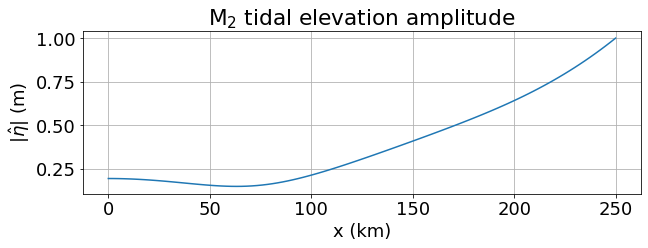

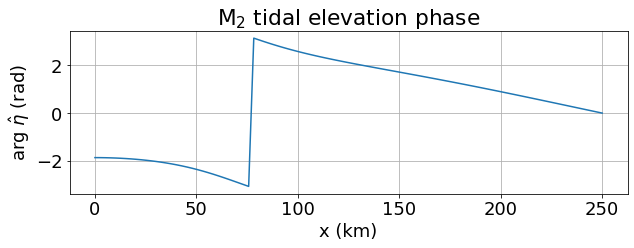

In [74]:
#@title
plt.figure(figsize=(10, 3))
plt.plot(x / 1000, np.abs(eta))
plt.xlabel('x (km)')
plt.ylabel('$|\hat{\eta}|$ (m)')
plt.title('M$_2$ tidal elevation amplitude')
plt.figure(figsize=(10, 3))
plt.plot(x / 1000, np.angle(eta))
plt.xlabel('x (km)')
plt.ylabel('arg $\hat{\eta}$ (rad)')
plt.title('M$_2$ tidal elevation phase')
plt.show()

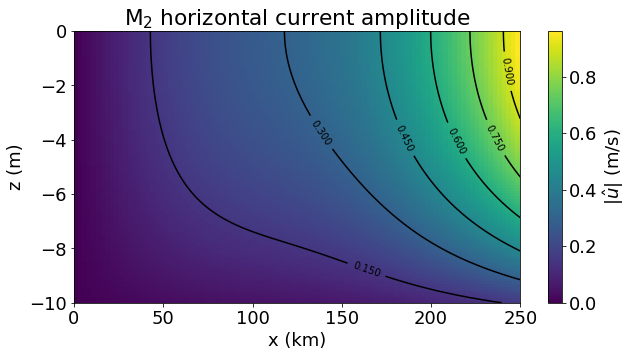

In [75]:
#@title
plt.figure(figsize=(10, 5))
contour_u = plt.pcolor(X/1000, Z, np.abs(u))
cbar = plt.colorbar(contour_u)
contour = plt.contour(X/1000, Z, np.abs(u), colors='k')
plt.clabel(contour, inline=1, fontsize=10)
cbar.set_label('$|\hat{u}|$ (m/s)')
plt.title('M$_2$ horizontal current amplitude')
plt.xlabel('x (km)')
plt.ylabel('z (m)')

# plt.figure(figsize=(5, 5))
# contour_u = plt.pcolor(X, Z, np.angle(u))
# cbar = plt.colorbar(contour_u)
# cbar.set_label('horizontal current phase (rad)')
plt.show()

## Plots for subtidal flows

### Stokes return flow

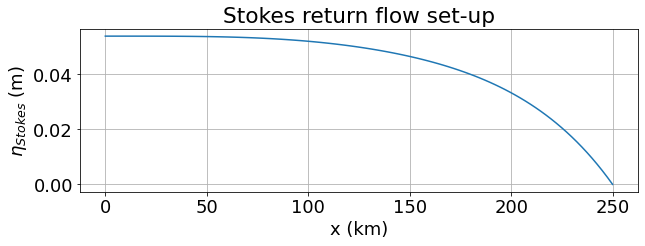

In [76]:
#@title
plt.figure(figsize=(10, 3))
plt.plot(x/1000, eta_Stokes)
plt.xlabel('x (km)')
plt.title('Stokes return flow set-up')
plt.ylabel('$\eta_{Stokes}$ (m)')
plt.show()

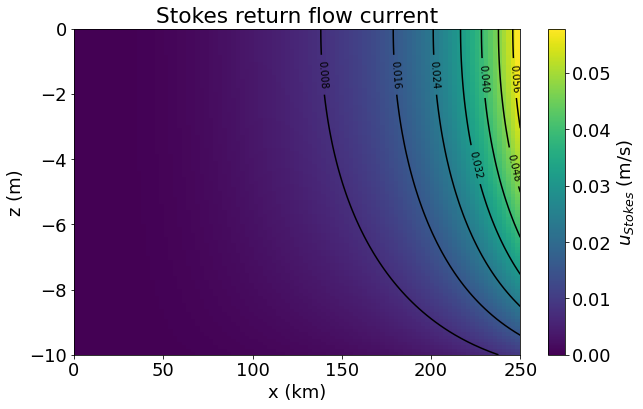

In [79]:
#@title
plt.figure(figsize=(10, 6))
cp = plt.pcolor(X/1000, Z, u_Stokes)
cb = plt.colorbar(cp)
cb.set_label('$u_{Stokes}$ (m/s)')
contour = plt.contour(X/1000, Z, u_Stokes, colors='k')
plt.clabel(contour, inline=1, fontsize=10)
plt.title('Stokes return flow current')
plt.xlabel('x (km)')
plt.ylabel('z (m)')
plt.show()

### Velocity-depth asymmetry

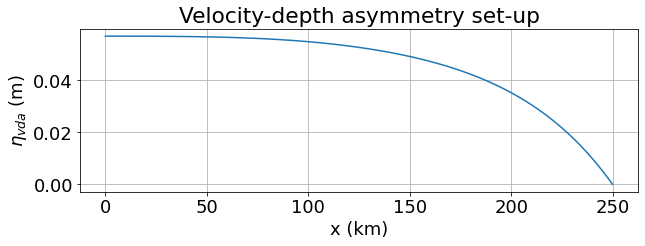

In [80]:
#@title
plt.figure(figsize=(10, 3))
plt.plot(x/1000, eta_vda)
plt.xlabel('x (km)')
plt.title('Velocity-depth asymmetry set-up')
plt.ylabel('$\eta_{vda}$ (m)')
plt.show()

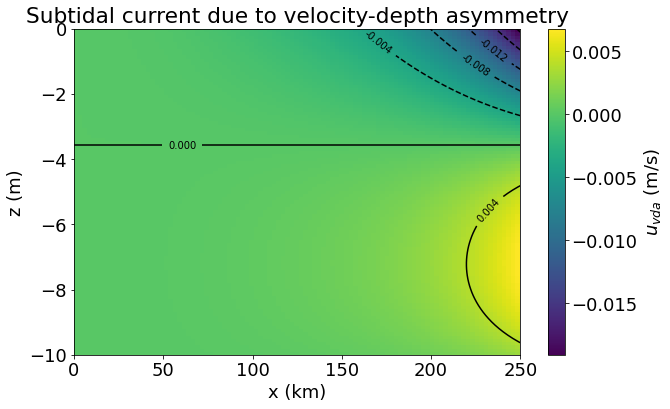

In [81]:
#@title
plt.figure(figsize=(10, 6))
cp = plt.pcolor(X/1000, Z, u_vda)
cb = plt.colorbar(cp)
cb.set_label('$u_{vda}$ (m/s)')
contour = plt.contour(X/1000, Z, u_vda, colors='k')
plt.clabel(contour, inline=1, fontsize=10)
plt.title('Subtidal current due to velocity-depth asymmetry')
plt.xlabel('x (km)')
plt.ylabel('z (m)')
plt.show()

### Advection

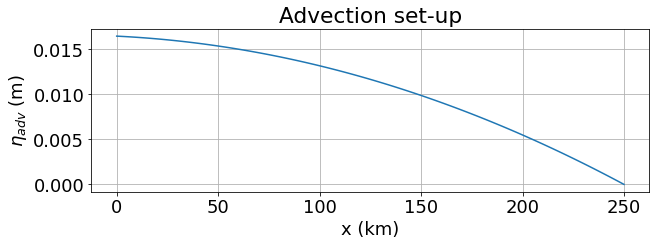

In [82]:
#@title
plt.figure(figsize=(10, 3))
plt.plot(x/1000, eta_adv)
plt.xlabel('x (km)')
plt.title('Advection set-up')
plt.ylabel('$\eta_{adv}$ (m)')
plt.show()

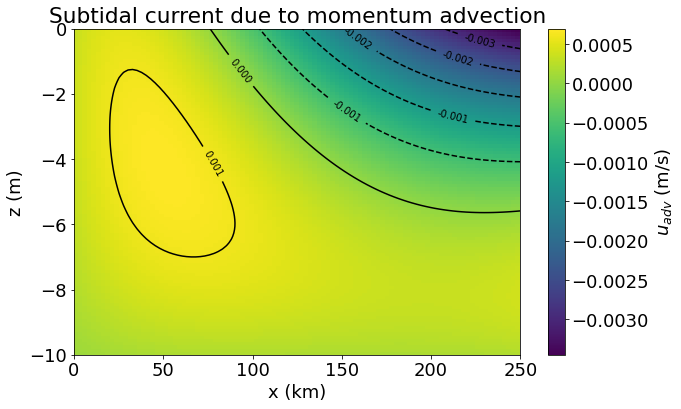

In [83]:
#@title
plt.figure(figsize=(10, 6))
cp = plt.pcolor(X/1000, Z, u_adv)
cb = plt.colorbar(cp)
cb.set_label('$u_{adv}$ (m/s)')
contour = plt.contour(X/1000, Z, u_adv, colors='k')
plt.clabel(contour, inline=1, fontsize=10)
plt.title('Subtidal current due to momentum advection')
plt.xlabel('x (km)')
plt.ylabel('z (m)')
plt.show()